# Setup

In [1]:
import glob
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from random import randint
import cv2

In [2]:
def file_lines_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    content = [(x.strip()).split() for x in content]
    return content

In [3]:
def get_file_name(path):
    basename = os.path.basename(path)
    onlyname = os.path.splitext(basename)[0]
    return onlyname

# Calculate GT/TP and Draw Graphs

In [4]:
def calc_iou(gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt = gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt > y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p > y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct")
        
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt < x_topleft_p):      
        return 0.0
    if(y_bottomright_gt < y_topleft_p):        
        return 0.0
    if(x_topleft_gt > x_bottomright_p):      
        return 0.0
    if(y_topleft_gt > y_bottomright_p):
        return 0.0
    
    GT_bbox_area = (x_bottomright_gt - x_topleft_gt + 1) * (y_bottomright_gt - y_topleft_gt + 1)
    Pred_bbox_area = (x_bottomright_p - x_topleft_p + 1 ) * (y_bottomright_p - y_topleft_p + 1)
    
    x_top_left = np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right - x_top_left + 1) * (y_bottom_right - y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [5]:
def process_single_image_results(gt_boxes, pred_boxes, iou_thr):

    detected_obj_boxes = []

    if len(pred_boxes) > 0 and len(gt_boxes) > 0:
    
        gt_idx_thr=[]
        pred_idx_thr=[]
        ious=[]

        for igb, gt_box in enumerate(gt_boxes):
            for ipb, pred_box in enumerate(pred_boxes):
                iou = calc_iou(gt_box, pred_box)

                if iou >= iou_thr:
                    detected_obj_boxes.append(gt_box)
#                 break
    
    return detected_obj_boxes

## Print IoUs and Boxes

In [6]:
gt_path = glob.glob("./graphs/bdd100k_60_70_GT/*.txt")

all_gt_boxes = []
for path in gt_path:
    contents = file_lines_to_list(path)
    for content in contents:
        all_gt_boxes.append([int(content[1]), int(content[2]), int(content[3]), int(content[4])])
        
print(len(all_gt_boxes))

310


In [7]:
print(len(gt_path))
print(gt_path[0])

274
./graphs/bdd100k_60_70_GT\b1ebfc3c-cc9c2bb8.txt


In [8]:
index = randint(0, len(gt_path)-1)
print(index)

87


In [9]:
path = gt_path[index]
img_name = get_file_name(path)
print(img_name)

b95dcb10-45d68fcc


In [10]:
index = randint(0, len(gt_path)-1)
print(index)

# index = 98

path = gt_path[index]
img_name = get_file_name(path)
print(img_name)

result_file_name = "60_70_enhanced_ver2_6080anchors_yolo_epoch_92"

gt_boxes_list = file_lines_to_list(f"./graphs/bdd100k_60_70_GT/{img_name}.txt")
det_boxes_list = file_lines_to_list(f"./graphs/{result_file_name}/{img_name}.txt")

print(gt_boxes_list)
print(det_boxes_list)

114
bc1e4645-76a7fd0e
[['person', '1162', '390', '1229', '558']]
[['person', '0.827160', '1170', '389', '1238', '555']]


In [11]:
iou_list = []
score_list = []
index_list = []

if len(det_boxes_list) > 0:
    for gt_box in gt_boxes_list:
        iou_list_i = []
        for det_box in det_boxes_list:
            array_gt = [int(gt_box[1]), int(gt_box[2]), int(gt_box[3]), int(gt_box[4])]
            array_det = [int(det_box[2]), int(det_box[3]), int(det_box[4]), int(det_box[5])]

            iou = calc_iou(array_gt, array_det)

            iou_list_i.append(iou)

        max_iou_i = np.amax(iou_list_i)
        index_max = np.argmax(iou_list_i)

        iou_list.append(max_iou_i)
        score_list.append(det_boxes_list[index_max][1])
        index_list.append(index_max)

else:
    for gt_box in gt_boxes_list:
        iou_list.append(0)
        
print(gt_boxes_list)
print("IoU", iou_list)
print("Score", score_list)
print("Index", index_list)

[['person', '1162', '390', '1229', '558']]
IoU [0.7629260819609345]
Score ['0.827160']
Index [0]


1 1


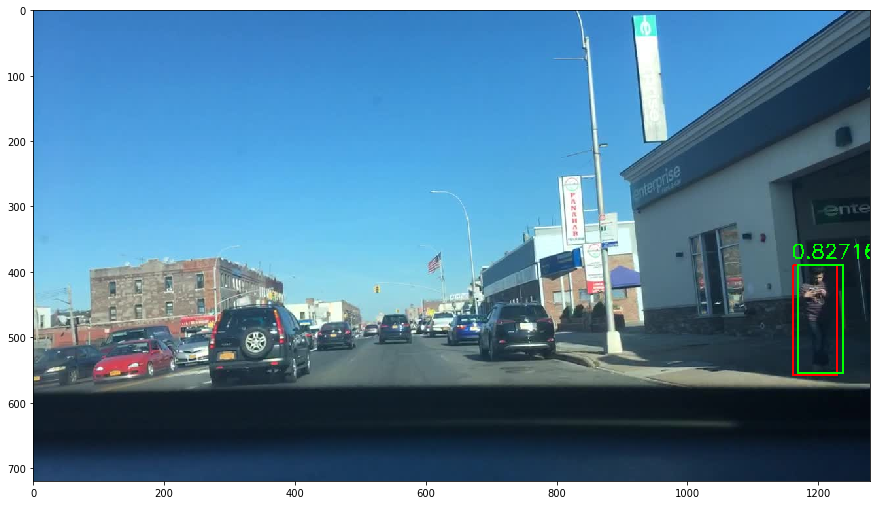

In [12]:
img = plt.imread(f"../datasets/bdd100k/bdd100k/bdd100k/images/100k/val/{img_name}.jpg")

gt_boxes = file_lines_to_list(f"./yolo-various-size/60-70/bdd100k_60_70_GT/{img_name}.txt")
det_boxes = file_lines_to_list(f"./graphs/{result_file_name}/{img_name}.txt")

print(len(gt_boxes), len(det_boxes))

dummy = img.copy()

for obj in gt_boxes:
    cv2.rectangle(dummy, (int(obj[1]), int(obj[2])), (int(obj[3]), int(obj[4])), (255, 0, 0), thickness = 2)
    
for obj in det_boxes:
    cv2.rectangle(dummy, (int(obj[2]), int(obj[3])), (int(obj[4]), int(obj[5])), (0, 255, 0), thickness = 2)
    cv2.putText(dummy, str(obj[1]), (int(obj[2])-10, int(obj[3])-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                                                            
plt.figure(figsize = (15, 10))
plt.imshow(dummy)
plt.show()

In [165]:
gray_scale = cv2.imread(f"../datasets/bdd100k/bdd100k/bdd100k/images/100k/val/{img_name}.jpg", 0)

gray_average_values = []
error = []

for i in range(len(gt_boxes_list)):
    box = gt_boxes_list[i]
    cropped = gray_scale[int(box[2]):int(box[4]), int(box[1]):int(box[3])]
    gray_average = np.average(cropped)
    
    gray_average_values.append(gray_average)
    error.append(1-iou_list[i])
    
print(gray_average_values)
print(error)

[64.31875]
[0.19243498817966898]


# Print Detection Results

In [22]:
result_file_name = "60_70_enhanced_res_mosaic_yolo_epoch_58"

for index in range(len(gt_path)):
    path = gt_path[index]
    img_name = get_file_name(path)

    gt_boxes_list = file_lines_to_list(f"./graphs/bdd100k_60_70_GT/{img_name}.txt")
    det_boxes_list = file_lines_to_list(f"./graphs/{result_file_name}/{img_name}.txt")

    iou_list = []
    score_list = []
    index_list = []

    if len(det_boxes_list) > 0:
        for gt_box in gt_boxes_list:
            iou_list_i = []
            for det_box in det_boxes_list:
                array_gt = [int(gt_box[1]), int(gt_box[2]), int(gt_box[3]), int(gt_box[4])]
                array_det = [int(det_box[2]), int(det_box[3]), int(det_box[4]), int(det_box[5])]

                iou = calc_iou(array_gt, array_det)

                iou_list_i.append(iou)

            max_iou_i = np.amax(iou_list_i)
            index_max = np.argmax(iou_list_i)

            iou_list.append(max_iou_i)
            score_list.append(det_boxes_list[index_max][1])
            index_list.append(index_max)

    else:
        for gt_box in gt_boxes_list:
            iou_list.append(0)

    img = cv2.imread(f"../datasets/bdd100k/bdd100k/bdd100k/images/100k/val/{img_name}.jpg")

    dummy = img.copy()

    for i in range(len(gt_boxes_list)):
        obj = gt_boxes_list[i]
        cv2.rectangle(dummy, (int(obj[1]), int(obj[2])), (int(obj[3]), int(obj[4])), (0, 0, 255), thickness = 2)
        cv2.putText(dummy, str("{:.4f}".format(iou_list[i])), (int(obj[1])-10, int(obj[2])-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    for obj in det_boxes_list:
        cv2.rectangle(dummy, (int(obj[2]), int(obj[3])), (int(obj[4]), int(obj[5])), (0, 255, 0), thickness = 2)

    cv2.imwrite(f"./yolo-various-size/60_70_res_ver2_mosaic_printed_conf020/{img_name}_det.jpg", dummy)
    print(index, f"{len(gt_path)}")

0 274
1 274
2 274
3 274
4 274
5 274
6 274
7 274
8 274
9 274
10 274
11 274
12 274
13 274
14 274
15 274
16 274
17 274
18 274
19 274
20 274
21 274
22 274
23 274
24 274
25 274
26 274
27 274
28 274
29 274
30 274
31 274
32 274
33 274
34 274
35 274
36 274
37 274
38 274
39 274
40 274
41 274
42 274
43 274
44 274
45 274
46 274
47 274
48 274
49 274
50 274
51 274
52 274
53 274
54 274
55 274
56 274
57 274
58 274
59 274
60 274
61 274
62 274
63 274
64 274
65 274
66 274
67 274
68 274
69 274
70 274
71 274
72 274
73 274
74 274
75 274
76 274
77 274
78 274
79 274
80 274
81 274
82 274
83 274
84 274
85 274
86 274
87 274
88 274
89 274
90 274
91 274
92 274
93 274
94 274
95 274
96 274
97 274
98 274
99 274
100 274
101 274
102 274
103 274
104 274
105 274
106 274
107 274
108 274
109 274
110 274
111 274
112 274
113 274
114 274
115 274
116 274
117 274
118 274
119 274
120 274
121 274
122 274
123 274
124 274
125 274
126 274
127 274
128 274
129 274
130 274
131 274
132 274
133 274
134 274
135 274
136 274
137 274
138 27

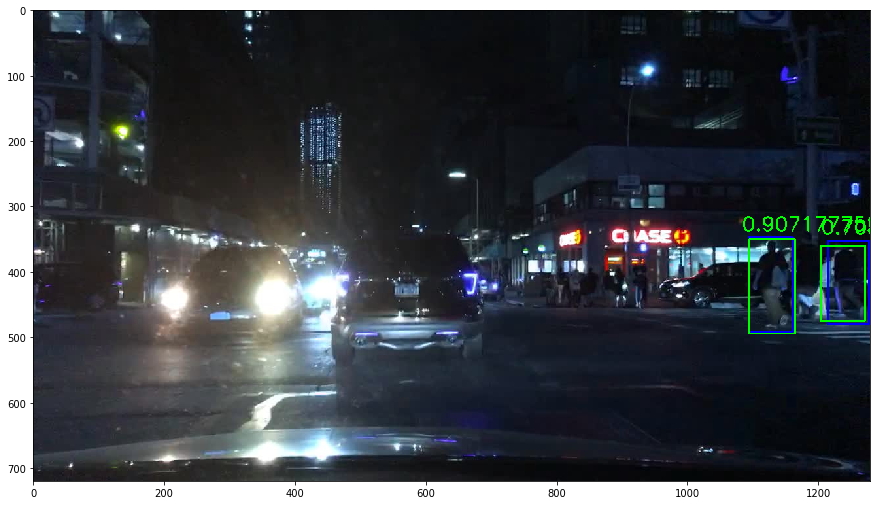

In [17]:
plt.figure(figsize = (15, 10))
plt.imshow(dummy)
plt.show()

In [202]:
# ================= RUN ================== #
result_file_name = "60_70_enhanced_res_6080anchors_yolo_epoch_57"

# full_gt_boxes_list = []
# iou_list = []

gray_average_values = []
error = []

i=0

for path in gt_path:
    img_name = get_file_name(path)

    gt_boxes_list = file_lines_to_list(f"./graphs/bdd100k_60_70_GT/{img_name}.txt")
    det_boxes_list = file_lines_to_list(f"./graphs/{result_file_name}/{img_name}.txt")
    
    gray_scale = cv2.imread(f"../datasets/bdd100k/bdd100k/bdd100k/images/100k/val/{img_name}.jpg", 0)

    if len(det_boxes_list) > 0:
        for gt_box in gt_boxes_list:
            iou_list_i = []
            for det_box in det_boxes_list:
                array_gt = [int(gt_box[1]), int(gt_box[2]), int(gt_box[3]), int(gt_box[4])]
                array_det = [int(det_box[2]), int(det_box[3]), int(det_box[4]), int(det_box[5])]

                iou = calc_iou(array_gt, array_det)

                iou_list_i.append(iou)

            max_iou_i = np.amax(iou_list_i)

            cropped = gray_scale[int(gt_box[2]):int(gt_box[4]), int(gt_box[1]):int(gt_box[3])]
            gray_average = np.average(cropped)
            
            gray_average_values.append(gray_average)
            error.append(1-max_iou_i)

    else:
        for gt_box in gt_boxes_list:
            cropped = gray_scale[int(gt_box[2]):int(gt_box[4]), int(gt_box[1]):int(gt_box[3])]
            gray_average = np.average(cropped)
            gray_average_values.append(gray_average)
            error.append(1)
    i+=1
    print(i,f"{len(gt_path)}")

1 274
2 274
3 274
4 274
5 274
6 274
7 274
8 274
9 274
10 274
11 274
12 274
13 274
14 274
15 274
16 274
17 274
18 274
19 274
20 274
21 274
22 274
23 274
24 274
25 274
26 274
27 274
28 274
29 274
30 274
31 274
32 274
33 274
34 274
35 274
36 274
37 274
38 274
39 274
40 274
41 274
42 274
43 274
44 274
45 274
46 274
47 274
48 274
49 274
50 274
51 274
52 274
53 274
54 274
55 274
56 274
57 274
58 274
59 274
60 274
61 274
62 274
63 274
64 274
65 274
66 274
67 274
68 274
69 274
70 274
71 274
72 274
73 274
74 274
75 274
76 274
77 274
78 274
79 274
80 274
81 274
82 274
83 274
84 274
85 274
86 274
87 274
88 274
89 274
90 274
91 274
92 274
93 274
94 274
95 274
96 274
97 274
98 274
99 274
100 274
101 274
102 274
103 274
104 274
105 274
106 274
107 274
108 274
109 274
110 274
111 274
112 274
113 274
114 274
115 274
116 274
117 274
118 274
119 274
120 274
121 274
122 274
123 274
124 274
125 274
126 274
127 274
128 274
129 274
130 274
131 274
132 274
133 274
134 274
135 274
136 274
137 274
138 274
139 

In [203]:
print(len(gray_average_values), len(error))

310 310


In [204]:
data = []

for i in range(len(gray_average_values)):
    data.append([gray_average_values[i], error[i]])

In [205]:
index = randint(0, len(gt_path)-1)
print(index)

print(data[index])

135
[16.938444278234854, 0.6018472291562655]


In [206]:
data = np.array(data)
data.shape

(310, 2)

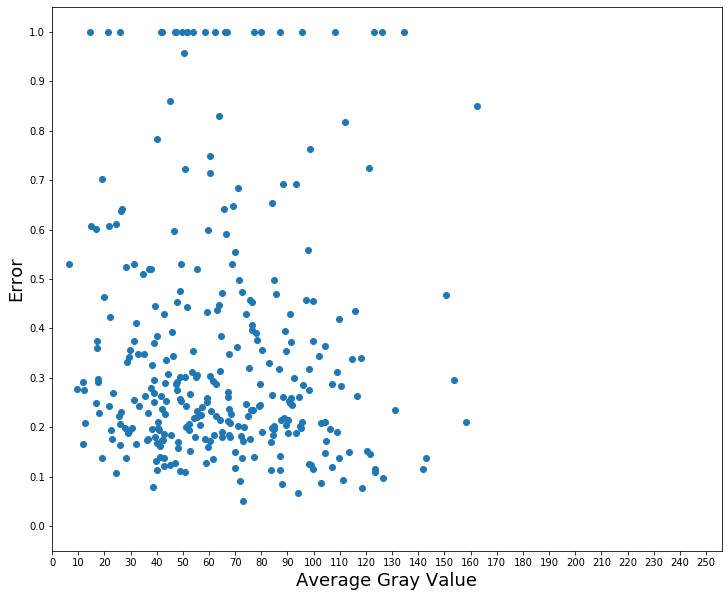

In [207]:
plt.figure(figsize=(12,10))
plt.ylim(-0.05, 1.05)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xlim(0, 256)
plt.xticks(np.arange(0, 256, 10))

plt.xlabel('Average Gray Value', fontsize=18)
plt.ylabel('Error', fontsize=18)
plt.scatter(data[:,0], data[:,1])
plt.show()

In [193]:
data_ = []

for i in range(len(gray_average_values)):
    data_.append([gray_average_values[i], 1-error[i]])
data_ = np.array(data_)
data_.shape

(310, 2)

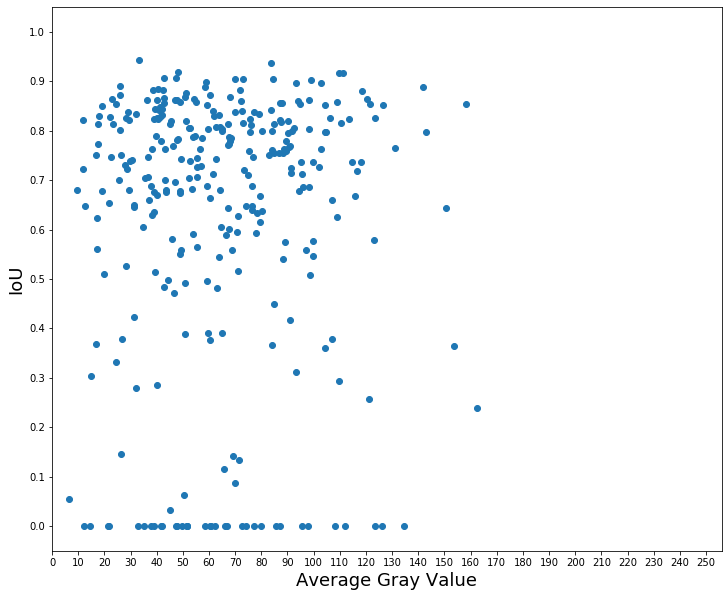

In [200]:
plt.figure(figsize=(12,10))
plt.ylim(-0.05, 1.05)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xlim(0, 256)
plt.xticks(np.arange(0, 256, 10))

plt.xlabel('Average Gray Value', fontsize=18)
plt.ylabel('IoU', fontsize=18)
plt.scatter(data_[:,0], data_[:,1])
plt.show()